In [1]:
from xfel.command_line.detector_residuals import phil_scope, ResidualsPlotter
from dxtbx.model.experiment_list import ExperimentListFactory
from dials.array_family import flex
from libtbx import easy_pickle
from iotbx.phil import parse
import os

overrides = """
residuals.exclude_outliers_from_refinement=False
residuals.plot_max=0.3
hierarchy_level=2
dot_size=10
colormap=YlGnBu_r
panel_numbers=False
plots.per_image_RMSDs_histogram=False
plots.deltaXY_by_deltapsi=False
plots.unit_cell_histograms=False
plots.include_radial_and_transverse=False
repredict_input_reflections=False
verbose=False
"""
params = phil_scope.fetch(sources = [parse(overrides)]).extract()

#original root = "/reg/d/psdm/cxi/cxi78513/res/brewster/paper_2017/metrology/dsd_t005plust010_000/refine_backonly"
root = "data/figure5"

In [2]:
def plot(expts_fn, refls_fn, tag):
    experiments = ExperimentListFactory.from_json_file(os.path.join(root, expts_fn), check_format = False)
    reflections = easy_pickle.load(os.path.join(root, refls_fn))
    params.tag = tag
    ResidualsPlotter(params, experiments, reflections).plot_all()

Dataset RMSD (microns) 926.4425836
Setting up stats...


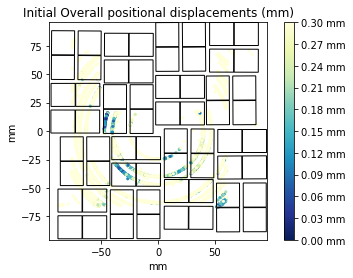

Dataset RMSD (microns) 797.889320882
Setting up stats...


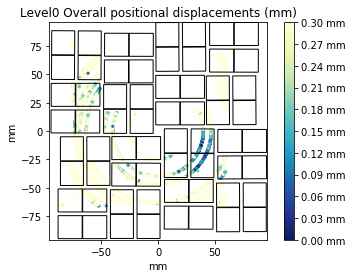

Dataset RMSD (microns) 630.07980133
Setting up stats...


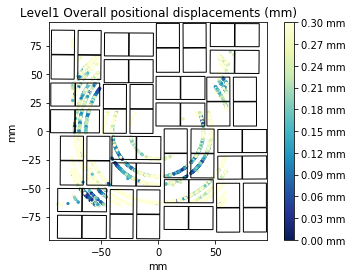

Dataset RMSD (microns) 361.261475329
Setting up stats...


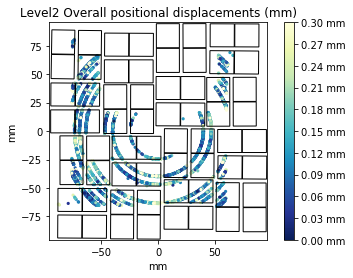

In [3]:
plot("split_filtered/experiments_00000.json", "split_filtered/reflections_00000.pickle", "Initial")
plot("dsd_refined_experiments_level0.json", "dsd_refined_reflections_level0.pickle", "Level0")
plot("dsd_refined_experiments_level1.json", "dsd_refined_reflections_level1.pickle", "Level1")
plot("dsd_refined_experiments_level2.json", "dsd_refined_reflections_level2.pickle", "Level2")

Number of scatterers: 4975
At special positions: 0
Unit cell: (92.893, 92.893, 130.438, 90, 90, 120)
Space group: P 61 2 2 (No. 178)
Miller array info: None
Observation type: None
Type of data: double, size=3001
Type of sigmas: double, size=3001
Number of Miller indices: 3001
Anomalous flag: True
Unit cell: (92.893, 92.893, 130.438, 90, 90, 120)
Space group: P 61 2 2 (No. 178)
(1, 0, 3) 683 77080.579795 9023605.50743
Not enough observations: (2, 0, 2) 14
Not enough observations: (2, 0, 3) 13
(2, 0, 0) 186 33244.1236559 1356707.45156
(1, 1, 0) 757 66991.5746367 22060245.3657
(1, 0, 0) 2125 75271.6734118 5218347.53224
Not enough observations: (2, 1, 1) 7
HKL not in reference: (0, 0, 1) 564
(1, 1, 2) 504 58709.593254 6127348.1033
Not enough observations: (1, 0, 4) 11
(2, 0, 1) 386 53785.3056995 2424496.58589
Not enough observations: (1, 1, 3) 1
Not enough observations: (2, 1, 0) 6
(1, 0, 2) 2700 79763.4392593 17445183.4119
(1, 0, 1) 1063 13320.3668862 753023.725917
(1, 1, 1) 869 41688.852

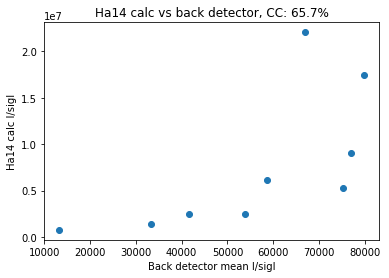

In [6]:
from iotbx import mtz
from dxtbx.model.experiment_list import ExperimentListFactory
from libtbx import easy_pickle
import copy
from cctbx.miller import map_to_asu
from scitbx.array_family import flex
from matplotlib import pyplot as plt
from iotbx.phil import parse
from xfel.command_line.cxi_merge import master_phil
from xfel.merging.general_fcalc import run
from matplotlib.backends.backend_pdf import PdfPages

write_pdf = False
if write_pdf:
  plt.figure(figsize=(4.42/2.54, 3.32/2.54))

params = parse(master_phil).extract()
params.model = "data/figure5/4OW3.pdb"
params.d_min = 5.0
params.d_max = 300.0
array = run(params)
array.show_summary()

experiments = ExperimentListFactory.from_json_file(os.path.join(root,"dsd_refined_experiments_level2.json"),
                                                   check_format=False)
reflections = easy_pickle.load(os.path.join(root, "dsd_refined_reflections_level2.pickle"))

idict = {}

for i, experiment in enumerate(experiments):
  refls = reflections.select(reflections['id'] == i)
  unique = copy.deepcopy(refls['miller_index'])
  map_to_asu(experiment.crystal.get_space_group().type(), False, unique)

  for j in xrange(len(refls)):
    hkl = unique[j]
    if hkl not in idict:
      idict[hkl] = flex.double()
    idict[hkl].append(refls['intensity.sum.value'][j])
    #idict[hkl].append(refls['isigi'][j])

x = flex.double()
y = flex.double()

data = array.data()#/array.sigmas()

for hkl in idict:
  if hkl not in array.indices():
    print "HKL not in reference:", hkl, len(idict[hkl])
    continue
  if len(idict[hkl]) < 20:
    print "Not enough observations:", hkl, len(idict[hkl])
    continue

  x.append(flex.mean(idict[hkl]))
  y.append(data[array.indices().first_index(hkl)])

  print hkl, len(idict[hkl]), x[-1], y[-1]

lc = flex.linear_correlation(x, y)

plt.scatter(x, y)

if write_pdf:
  ax = plt.gca()
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  ax.get_xaxis().tick_bottom()
else:
  plt.title("Ha14 calc vs back detector, CC: %.1f%%"%(lc.coefficient()*100))
  plt.xlabel("Back detector mean I/sigI")
  plt.ylabel("Ha14 calc I/sigI")

plt.subplots_adjust(wspace=0, hspace=0)

if write_pdf:
  pp = PdfPages('back_detector_correlation.pdf')
  for i in plt.get_fignums():
    pp.savefig(plt.figure(i))
  pp.close()
else:
  plt.show()

To see image in panel b, use dials.image_viewer data/figure5/runs11-22_max.cbf